# ZNE with indirect-control VQE
---

This experiment is:

- Qubit: 7, layer: 30
- System has noise-free time evolution.
- Target observable: Transverse field Ising Hamiltonian.
- Ansatz time-evolution: Noise-free time-evolution with XY, Ising, and Heisenberg Hamiltonians.
- Constraint: True

## (1) Import and setup

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
from tabulate import tabulate


In [2]:
# Set the default font to be LaTeX compliant.
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Computer Modern Roman"
plt.rcParams["text.usetex"] = True

# Set a global font size.
font_size = 11
plt.rcParams["font.size"] = font_size
plt.rcParams["axes.labelsize"] = font_size
plt.rcParams["xtick.labelsize"] = font_size
plt.rcParams["ytick.labelsize"] = font_size
plt.rcParams["legend.fontsize"] = 10

# Others
plot_titles = {
    "xy": "XY ansatz",
    "heisenberg": "Heisenberg ansatz",
    "ising": "Ising ansatz"
}

plot_export_names = {
    "xy": "xy_ansatz_noise_free_tevo.eps",
    "heisenberg": "heisenberg_ansatz_noise_free_tevo.eps",
    "ising": "ising_ansatz_noise_free_tevo.eps",
    "compiled": "compiled.eps",
    "heisenberg_further1": "heisenberg_ansatz_further_ric3.eps"
}

plot_colors = [
    "darkred",
    "darkgreen",
    "darkblue",
    "darkmagenta",
    "darkcyan",
    "magenta",
    "green",
    "goldenrod",
    "black",
    "orange",
    "purple"
    ]

## (2) Loading the experimental data from JSON files

The raw experimenal data are availabe at `data\` folder

In [3]:
base_path = "data"
models = ["xy", "ising", "heisenberg"]

ALL_RAW_DATA = {
    model: {
        "vqe": [],
        "redundant": [],
        "zne": [],
        "noiseoff": []  # Added to match the original structure
    } for model in models
}

for model in models:
    model_path = os.path.join(base_path, model)
    
    try:
        filenames = os.listdir(model_path)
    except Exception as e:
        print(f"[ERROR] Failed to list files in {model_path}: {e}")
        continue

    for filename in filenames:
        if not filename.endswith(".json"):
            continue

        filepath = os.path.join(model_path, filename)
        
        try:
            with open(filepath, "r") as f:
                data = json.load(f)
        except json.JSONDecodeError:
            print(f"[ERROR] Failed to parse JSON in file: {filepath}")
            continue
        except Exception as e:
            print(f"[ERROR] Failed to load file {filepath}: {e}")
            continue

        filename_lower = filename.lower()
        if filename_lower.endswith("_vqe.json"):
            ALL_RAW_DATA[model]["vqe"].append(data)
        elif filename_lower.endswith("_redundant.json"):
            ALL_RAW_DATA[model]["redundant"].append(data)
        elif filename_lower.endswith("_zne.json"):
            ALL_RAW_DATA[model]["zne"].append(data)
        elif filename_lower.endswith("_noise_off.json"):
            ALL_RAW_DATA[model]["noiseoff"].append(data)


## (3) Extracting data

<img src="../../figures/quantum_cicuit_standard_vs_redundant.jpg" alt="std_vs_redun_circuit" width="800"/>


Now lets extract some unformations.




### (A) The exact minimum eigen value

Our target Hamiltonian is

$$H_{Ising} = \sum_{k=1}^{N-1} X_{k}X_{k+1} + \sum_{k=1}^{N}Z_k$$

where $N=7$.

The exact minimum eigen value of the target observable (i.e. tranverse field Ising Hamiltonian for a 7-qubit system) is $-8.566772233505624$. This value is recored in `file_name_prefix_ZNE.json` files.

In [4]:
exact_sol: float = -8.566772233505624
print(f"Exact solution: {exact_sol}")

Exact solution: -8.566772233505624


### (B) VQE estimations (noise is on)

The noise level ($\lambda$) is defined as 
$$\lambda = n_R + 2 n_{CZ} + N n_T + n_Y$$

where $nR, n_{CZ}, n_T, $ and $nY$ are proportinal to number of *noisy* rotation gates, two-qubit $CZ$ gate, the time-evolution gates, and Y gates. For the above circuit in the standard circuit (i.e. unboosted noise) noise level is $6$ while in the redundant circuit (i.e. boosted noise) noise level is $18$.

In [5]:
noise_levels: list=[6, 18]
extrapolated_noise: int = 0

### (C) Processing raw data

In [6]:
ALL_PROCESSED_DATA = {
    model: {
        "vqe": {},
        "redundant": {},
        "zne": {},
        "noiseoff": {}  # Added to match the original structure
    } for model in models
}

for model in models:
    
    ALL_PROCESSED_DATA[model]["vqe"] = {
        "mean": np.mean(
                    ALL_RAW_DATA[model]["vqe"][0]["output"]["optimized_minimum_cost"]
                ),
        "std": np.std(
            ALL_RAW_DATA[model]["vqe"][0]["output"]["optimized_minimum_cost"]
        )
    }

    ALL_PROCESSED_DATA[model]["redundant"] = {
        "noise_levels": noise_levels,
        "mean": [
            np.mean(
                [ALL_RAW_DATA[model]["redundant"][i]["output"]["data_points"][0][4] for i in range(len(ALL_RAW_DATA[model]["redundant"]))]

            ),
            np.mean(
                [ALL_RAW_DATA[model]["redundant"][i]["output"]["data_points"][1][4] for i in range(len(ALL_RAW_DATA[model]["redundant"]))]

            )
        ],
        "std": [
            np.std(
                [ALL_RAW_DATA[model]["redundant"][i]["output"]["data_points"][0][4] for i in range(len(ALL_RAW_DATA[model]["redundant"]))]

            ),
            np.std(
                [ALL_RAW_DATA[model]["redundant"][i]["output"]["data_points"][1][4] for i in range(len(ALL_RAW_DATA[model]["redundant"]))]

            )
        ],
    }

    ALL_PROCESSED_DATA[model]["zne"] = {
        "mean": np.mean(
            [ALL_RAW_DATA[model]["zne"][i]["output"]["zne_values"]["extrapolated_value"]for i in range(len(ALL_RAW_DATA[model]["zne"]))]
        ),
        "std": np.std(
            [ALL_RAW_DATA[model]["zne"][i]["output"]["zne_values"]["extrapolated_value"]for i in range(len(ALL_RAW_DATA[model]["zne"]))]
        )
    }

    ALL_PROCESSED_DATA[model]["noiseoff"] = {
        "mean": np.mean(
            ALL_RAW_DATA[model]["noiseoff"][0]["output"]["optimized_minimum_cost"]
        ),
        "std": np.std(
            ALL_RAW_DATA[model]["noiseoff"][0]["output"]["optimized_minimum_cost"]
        )
    }

In [7]:
ALL_PROCESSED_DATA

{'xy': {'vqe': {'mean': -7.588028443549487, 'std': 0.10673748123865216},
  'redundant': {'noise_levels': [6, 18],
   'mean': [-7.5880284435494385, -6.28454723195193],
   'std': [0.10673748123865909, 0.1627423405639358]},
  'zne': {'mean': -8.239769049348192, 'std': 0.08912986050559951},
  'noiseoff': {'mean': -8.369342611101047, 'std': 0.15124979844206457}},
 'ising': {'vqe': {'mean': -6.55965352212981, 'std': 0.21602941424704925},
  'redundant': {'noise_levels': [6, 18],
   'mean': [-6.559653522129835, -5.4942771928304195],
   'std': [0.21602941424705321, 0.22127314516423383]},
  'zne': {'mean': -7.092341686779543, 'std': 0.22490941122324423},
  'noiseoff': {'mean': -7.2800222505553736, 'std': 0.24690963596051196}},
 'heisenberg': {'vqe': {'mean': -5.97122563622368, 'std': 0.3274932846028536},
  'redundant': {'noise_levels': [6, 18],
   'mean': [-5.97122563622362, -4.7016950863487645],
   'std': [0.3274932846028536, 0.3141739134474781]},
  'zne': {'mean': -6.605990911161048, 'std': 0.

In [8]:
# Prepare rows for tabulation
rows = []
for model, methods in ALL_PROCESSED_DATA.items():
    for method, stats in methods.items():
        if method == "redundant":
            for lvl, m, s in zip(stats['noise_levels'], stats['mean'], stats['std']):
                rows.append([model, f"{method} (noise={lvl})", m, s])
        elif stats:  # ignore empty "noiseoff"
            rows.append([model, method, stats['mean'], stats['std']])
        else:
            rows.append([model, method, "N/A", "N/A"])

# Print table
headers = ["Model", "Category", "Mean", "Std"]
print(tabulate(rows, headers=headers))

Model       Category                  Mean        Std
----------  --------------------  --------  ---------
xy          vqe                   -7.58803  0.106737
xy          redundant (noise=6)   -7.58803  0.106737
xy          redundant (noise=18)  -6.28455  0.162742
xy          zne                   -8.23977  0.0891299
xy          noiseoff              -8.36934  0.15125
ising       vqe                   -6.55965  0.216029
ising       redundant (noise=6)   -6.55965  0.216029
ising       redundant (noise=18)  -5.49428  0.221273
ising       zne                   -7.09234  0.224909
ising       noiseoff              -7.28002  0.24691
heisenberg  vqe                   -5.97123  0.327493
heisenberg  redundant (noise=6)   -5.97123  0.327493
heisenberg  redundant (noise=18)  -4.7017   0.314174
heisenberg  zne                   -6.60599  0.345675
heisenberg  noiseoff              -6.92055  0.197668


## (4) Plot

Finally we can plot the results.

### (A) XY ansatz plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


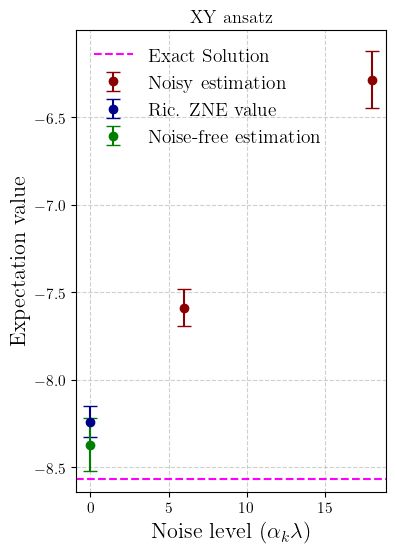

Figure saved as (in 'plots' folder): xy_ansatz_ric.eps


In [9]:
# Plot size
plt.figure(figsize=(4, 6))
# PLot name
plot_name: str= "xy_ansatz_ric.eps"
DATA= ALL_PROCESSED_DATA["xy"]

# Noisy estimation
plt.errorbar(
    x=noise_levels,
    y=DATA["redundant"]["mean"],
    yerr=DATA["redundant"]["std"], 
    fmt="o", 
    ecolor=plot_colors[0],
    capsize=5, 
    label="Noisy estimation", 
    color=plot_colors[0]
)
# Extrapolated
plt.errorbar(
    x=extrapolated_noise, 
    y=DATA["zne"]["mean"], 
    yerr=DATA["zne"]["std"], 
    fmt="o", 
    ecolor=plot_colors[2],
    capsize=5, 
    label="Ric. ZNE value", 
    color=plot_colors[2]
)
# Noise-free 
plt.errorbar(
    x=0, 
    y=DATA["noiseoff"]["mean"], 
    yerr=DATA["noiseoff"]["std"], 
    fmt="o", 
    ecolor=plot_colors[6],
    capsize=5, 
    label="Noise-free estimation", 
    color=plot_colors[6]
)
# Exact solution
plt.axhline(y=exact_sol, color=plot_colors[5], linestyle="--", label=f"Exact Solution")

# Labels and title
plt.xlabel(r"Noise level ($\alpha_k\lambda$)", fontsize=16)
plt.ylabel("Expectation value", fontsize=16)
plt.title(plot_titles["xy"])
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(loc="upper left", fontsize=14, frameon=False)
# Save as eps
plt.savefig(f"plots/{plot_name}", format="eps")
plt.show()
print("Figure saved as (in 'plots' folder):",  plot_name)

### (B) Ising ansatz plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


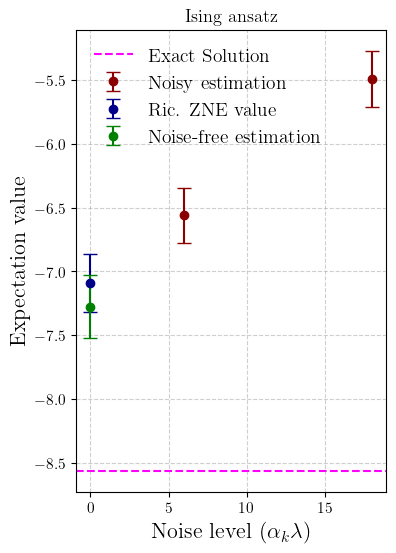

Figure saved as (in 'plots' folder): ising_ansatz_ric.eps


In [10]:
# Plot size
plt.figure(figsize=(4, 6))
# PLot name
plot_name: str= "ising_ansatz_ric.eps"
DATA= ALL_PROCESSED_DATA["ising"]

# Noisy estimation
plt.errorbar(
    x=noise_levels,
    y=DATA["redundant"]["mean"],
    yerr=DATA["redundant"]["std"], 
    fmt="o", 
    ecolor=plot_colors[0],
    capsize=5, 
    label="Noisy estimation", 
    color=plot_colors[0]
)
# Extrapolated
plt.errorbar(
    x=extrapolated_noise, 
    y=DATA["zne"]["mean"], 
    yerr=DATA["zne"]["std"], 
    fmt="o", 
    ecolor=plot_colors[2],
    capsize=5, 
    label="Ric. ZNE value", 
    color=plot_colors[2]
)
# Noise-free 
plt.errorbar(
    x=0, 
    y=DATA["noiseoff"]["mean"], 
    yerr=DATA["noiseoff"]["std"], 
    fmt="o", 
    ecolor=plot_colors[6],
    capsize=5, 
    label="Noise-free estimation", 
    color=plot_colors[6]
)
# Exact solution
plt.axhline(y=exact_sol, color=plot_colors[5], linestyle="--", label=f"Exact Solution")

# Labels and title
plt.xlabel(r"Noise level ($\alpha_k\lambda$)", fontsize=16)
plt.ylabel("Expectation value", fontsize=16)
plt.title(plot_titles["ising"])
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(loc="upper left", fontsize=14, frameon=False)
# Save as eps
plt.savefig(f"plots/{plot_name}", format="eps")
plt.show()
print("Figure saved as (in 'plots' folder):",  plot_name)

### (C) Heisenberg ansatz plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


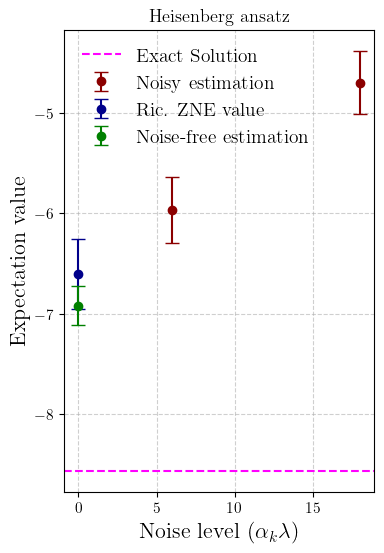

Figure saved as (in 'plots' folder): hesisenberg_ansatz_ric.eps


In [11]:
# Plot size
plt.figure(figsize=(4, 6))
# PLot name
plot_name: str= "hesisenberg_ansatz_ric.eps"
DATA= ALL_PROCESSED_DATA["heisenberg"]

# Noisy estimation
plt.errorbar(
    x=noise_levels,
    y=DATA["redundant"]["mean"],
    yerr=DATA["redundant"]["std"], 
    fmt="o", 
    ecolor=plot_colors[0],
    capsize=5, 
    label="Noisy estimation", 
    color=plot_colors[0]
)
# Extrapolated
plt.errorbar(
    x=extrapolated_noise, 
    y=DATA["zne"]["mean"], 
    yerr=DATA["zne"]["std"], 
    fmt="o", 
    ecolor=plot_colors[2],
    capsize=5, 
    label="Ric. ZNE value", 
    color=plot_colors[2]
)
# Noise-free 
plt.errorbar(
    x=0, 
    y=DATA["noiseoff"]["mean"], 
    yerr=DATA["noiseoff"]["std"], 
    fmt="o", 
    ecolor=plot_colors[6],
    capsize=5, 
    label="Noise-free estimation", 
    color=plot_colors[6]
)
# Exact solution
plt.axhline(y=exact_sol, color=plot_colors[5], linestyle="--", label=f"Exact Solution")

# Labels and title
plt.xlabel(r"Noise level ($\alpha_k\lambda$)", fontsize=16)
plt.ylabel("Expectation value", fontsize=16)
plt.title(plot_titles["heisenberg"])
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(loc="upper left", fontsize=14, frameon=False)
# Save as eps
plt.savefig(f"plots/{plot_name}", format="eps")
plt.show()
print("Figure saved as (in 'plots' folder):",  plot_name)

## (5) Compiled plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


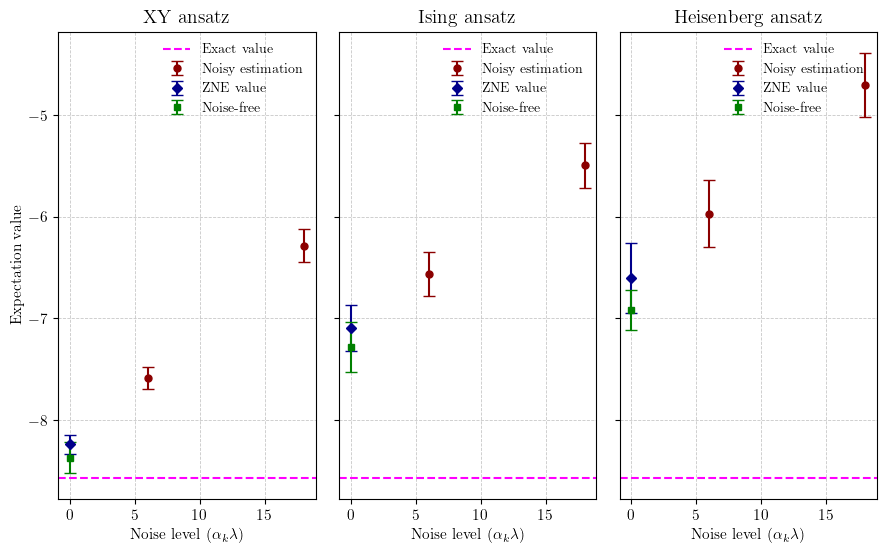

In [12]:
plot_name: str = "compiled_ansatz_noise_free_tevo.eps"
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(9, 6), sharey=True)

for i, model in enumerate(["xy", "ising", "heisenberg"]):
    ax = axs[i]
    DATA = ALL_PROCESSED_DATA[model]

    # Noisy Estimation
    ax.errorbar(
        x=noise_levels,
        y=DATA["redundant"]["mean"],
        yerr=DATA["redundant"]["std"],
        fmt="o",
        ecolor=plot_colors[0],
        capsize=4,
        label="Noisy estimation",
        color=plot_colors[0],
        markersize=5
    )

    # ZNE Extrapolated
    ax.errorbar(
        x=extrapolated_noise,
        y=DATA["zne"]["mean"],
        yerr=DATA["zne"]["std"],
        fmt="D",
        ecolor=plot_colors[2],
        capsize=4,
        label="ZNE value",
        color=plot_colors[2],
        markersize=5
    )

    # Noise-free Estimation
    ax.errorbar(
        x=0,
        y=DATA["noiseoff"]["mean"],
        yerr=DATA["noiseoff"]["std"],
        fmt="s",
        ecolor=plot_colors[6],
        capsize=4,
        label="Noise-free",
        color=plot_colors[6],
        markersize=5
    )

    # Exact Value
    ax.axhline(
        y=exact_sol,
        color=plot_colors[5],
        linestyle="--",
        linewidth=1.5,
        label="Exact value"
    )

    # Titles and Labels
    ax.set_title(plot_titles[model], fontsize=14)
    ax.set_xlabel(r"Noise level ($\alpha_k\lambda$)")
    ax.grid(True, linestyle="--", linewidth=0.6, alpha=0.7)

    if i == 0:
        ax.set_ylabel("Expectation value")

    # ✅ Legend in top right
    ax.legend(loc="upper right", frameon=False)

# Layout tweaks
plt.tight_layout(w_pad=1.2, h_pad=0.3)
plt.subplots_adjust(top=0.88)

# Optional: Save
plt.savefig(f"plots/{plot_name}", format="eps")

plt.show()


---

## (6) Further studies on Heisenberg ansatz

### (A) Load JSON data

In [13]:
# New model folders
heisenberg_further = ["heisenberg-ric3", "heisenberg-ricmul"]
base_path = "data"

# Initialize structure for new models only if not already in ALL_RAW_DATA
for model in heisenberg_further:
    ALL_RAW_DATA.setdefault(model, {
        "vqe": [],
        "redundant": [],
        "zne": [],
        "noiseoff": []
    })

# Load and append data
for model in heisenberg_further:
    model_path = os.path.join(base_path, model)

    try:
        filenames = os.listdir(model_path)
    except Exception as e:
        print(f"[ERROR] Failed to list files in {model_path}: {e}")
        continue

    for filename in filenames:
        if not filename.endswith(".json"):
            continue

        filepath = os.path.join(model_path, filename)

        try:
            with open(filepath, "r") as f:
                data = json.load(f)
        except json.JSONDecodeError:
            print(f"[ERROR] Failed to parse JSON in file: {filepath}")
            continue
        except Exception as e:
            print(f"[ERROR] Failed to load file {filepath}: {e}")
            continue

        filename_upper = filename.upper()
        if "ZNE" in filename_upper:
            ALL_RAW_DATA[model]["zne"].append(data)
        elif "REDUNDANT" in filename_upper:
            ALL_RAW_DATA[model]["redundant"].append(data)
        elif filename_upper.endswith("_VQE.JSON"):
            ALL_RAW_DATA[model]["vqe"].append(data)
        elif filename_upper.endswith("_NOISE_OFF.JSON"):
            ALL_RAW_DATA[model]["noiseoff"].append(data)


### (B) Processing raw data

In [14]:
for model in ["heisenberg-ric3", "heisenberg-ricmul"]:
    if model == "heisenberg-ricmul":
        noise_levels = ["(4, 2)", "(12,6)", "(20, 6)"]
    else:
        noise_levels = [6, 18, 26]
    ALL_PROCESSED_DATA[model] = {
        "vqe": {
            "mean": np.mean(ALL_RAW_DATA[model]["vqe"][0]["output"]["optimized_minimum_cost"]),
            "std": np.std(ALL_RAW_DATA[model]["vqe"][0]["output"]["optimized_minimum_cost"])
        },
        "redundant": {
            "noise_levels": noise_levels,
            "mean": [
                np.mean([
                    ALL_RAW_DATA[model]["redundant"][i]["output"]["data_points"][0][4]
                    for i in range(len(ALL_RAW_DATA[model]["redundant"]))
                ]),
                np.mean([
                    ALL_RAW_DATA[model]["redundant"][i]["output"]["data_points"][1][4]
                    for i in range(len(ALL_RAW_DATA[model]["redundant"]))
                ]),
                np.mean([
                    ALL_RAW_DATA[model]["redundant"][i]["output"]["data_points"][2][4]
                    for i in range(len(ALL_RAW_DATA[model]["redundant"]))
                ])
            ],
            "std": [
                np.std([
                    ALL_RAW_DATA[model]["redundant"][i]["output"]["data_points"][0][4]
                    for i in range(len(ALL_RAW_DATA[model]["redundant"]))
                ]),
                np.std([
                    ALL_RAW_DATA[model]["redundant"][i]["output"]["data_points"][1][4]
                    for i in range(len(ALL_RAW_DATA[model]["redundant"]))
                ]),
                np.std([
                    ALL_RAW_DATA[model]["redundant"][i]["output"]["data_points"][2][4]
                    for i in range(len(ALL_RAW_DATA[model]["redundant"]))
                ])
            ]
        },
        "zne": {
            "mean": np.mean([
                ALL_RAW_DATA[model]["zne"][i]["output"]["zne_values"]["extrapolated_value"]
                for i in range(len(ALL_RAW_DATA[model]["zne"]))
            ]),
            "std": np.std([
                ALL_RAW_DATA[model]["zne"][i]["output"]["zne_values"]["extrapolated_value"]
                for i in range(len(ALL_RAW_DATA[model]["zne"]))
            ])
        },
        "noiseoff": {
            "mean": np.mean(ALL_RAW_DATA[model]["noiseoff"][0]["output"]["optimized_minimum_cost"]),
            "std": np.std(ALL_RAW_DATA[model]["noiseoff"][0]["output"]["optimized_minimum_cost"])
        }
    }


In [15]:
# Prepare rows for tabulation
rows = []
for model, methods in ALL_PROCESSED_DATA.items():
    for method, stats in methods.items():
        if method == "redundant":
            for lvl, m, s in zip(stats['noise_levels'], stats['mean'], stats['std']):
                rows.append([model, f"{method} (noise={lvl})", m, s])
        elif stats:  # ignore empty "noiseoff"
            rows.append([model, method, stats['mean'], stats['std']])
        else:
            rows.append([model, method, "N/A", "N/A"])
    
    # Add divider (blank row)
    rows.append(["", "", "", ""])  # Or use ["-"*10, "-"*10, "-"*10, "-"*10] for lines

# Print table
headers = ["Model", "Category", "Mean", "Std"]
print(tabulate(rows, headers=headers))


Model              Category                   Mean                 Std
-----------------  -------------------------  -------------------  -------------------
xy                 vqe                        -7.588028443549487   0.10673748123865216
xy                 redundant (noise=6)        -7.5880284435494385  0.10673748123865909
xy                 redundant (noise=18)       -6.28454723195193    0.1627423405639358
xy                 zne                        -8.239769049348192   0.08912986050559951
xy                 noiseoff                   -8.369342611101047   0.15124979844206457

ising              vqe                        -6.55965352212981    0.21602941424704925
ising              redundant (noise=6)        -6.559653522129835   0.21602941424705321
ising              redundant (noise=18)       -5.4942771928304195  0.22127314516423383
ising              zne                        -7.092341686779543   0.22490941122324423
ising              noiseoff                   -7.2800222505

### (C) Plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


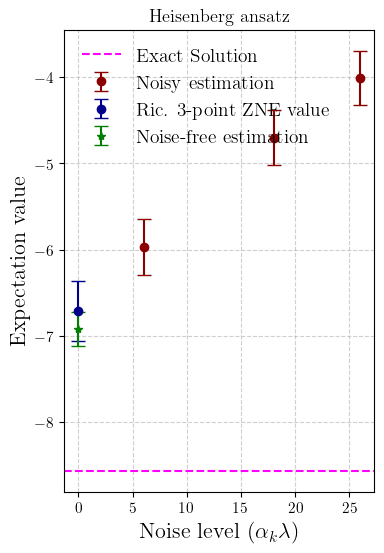

Figure saved as (in 'plots' folder): heisenberg_ansatz_ric3.eps


In [16]:
# Plot size
plt.figure(figsize=(4, 6))

# Plot name (fixed typo)
plot_name = "heisenberg_ansatz_ric3.eps"

# Data for heisenberg-ric3
DATA = ALL_PROCESSED_DATA["heisenberg-ric3"]
NOISE = DATA["redundant"]["noise_levels"]
# Noisy estimation (redundant)
plt.errorbar(
    x=NOISE,
    y=DATA["redundant"]["mean"],
    yerr=DATA["redundant"]["std"],
    fmt="o",
    ecolor=plot_colors[0],
    capsize=5,
    label="Noisy estimation",
    color=plot_colors[0]
)

# Extrapolated (ZNE)
plt.errorbar(
    x=extrapolated_noise,
    y=DATA["zne"]["mean"],
    yerr=DATA["zne"]["std"],
    fmt="o",
    ecolor=plot_colors[2],
    capsize=5,
    label="Ric. 3-point ZNE value",
    color=plot_colors[2]
)

# Noise-free estimation
plt.errorbar(
    x=0,
    y=DATA["noiseoff"]["mean"],
    yerr=DATA["noiseoff"]["std"],
    fmt="*",
    ecolor=plot_colors[6],
    capsize=5,
    label="Noise-free estimation",
    color=plot_colors[6]
)

# Exact solution line
plt.axhline(
    y=exact_sol,
    color=plot_colors[5],
    linestyle="--",
    label="Exact Solution"
)

# Labels and title (updated to heisenberg-ric3)
plt.xlabel(r"Noise level ($\alpha_k\lambda$)", fontsize=16)
plt.ylabel("Expectation value", fontsize=16)
plt.title(plot_titles["heisenberg"])
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(loc="upper left", fontsize=14, frameon=False)

# Save as EPS
plt.savefig(f"plots/{plot_name}", format="eps")
plt.show()

print("Figure saved as (in 'plots' folder):", plot_name)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


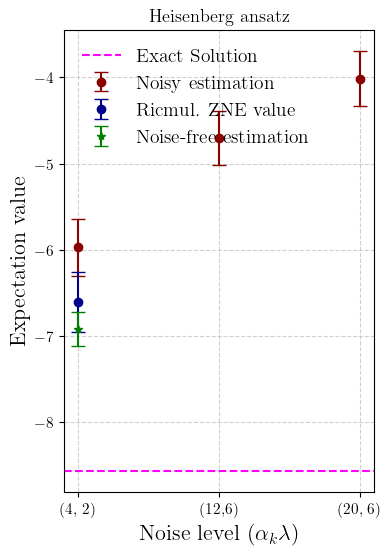

Figure saved as (in 'plots' folder): heisenberg_ansatz_ricmul.eps


In [17]:
# Plot size
plt.figure(figsize=(4, 6))

# Plot name (fixed typo)
plot_name = "heisenberg_ansatz_ricmul.eps"

# Data for heisenberg-ric3
DATA = ALL_PROCESSED_DATA["heisenberg-ricmul"]
NOISE = DATA["redundant"]["noise_levels"]
# Noisy estimation (redundant)
plt.errorbar(
    x=NOISE,
    y=DATA["redundant"]["mean"],
    yerr=DATA["redundant"]["std"],
    fmt="o",
    ecolor=plot_colors[0],
    capsize=5,
    label="Noisy estimation",
    color=plot_colors[0]
)

# Extrapolated (ZNE)
plt.errorbar(
    x=extrapolated_noise,
    y=DATA["zne"]["mean"],
    yerr=DATA["zne"]["std"],
    fmt="o",
    ecolor=plot_colors[2],
    capsize=5,
    label="Ricmul. ZNE value",
    color=plot_colors[2]
)

# Noise-free estimation
plt.errorbar(
    x=0,
    y=DATA["noiseoff"]["mean"],
    yerr=DATA["noiseoff"]["std"],
    fmt="*",
    ecolor=plot_colors[6],
    capsize=5,
    label="Noise-free estimation",
    color=plot_colors[6]
)

# Exact solution line
plt.axhline(
    y=exact_sol,
    color=plot_colors[5],
    linestyle="--",
    label="Exact Solution"
)

# Labels and title (updated to heisenberg-ric3)
plt.xlabel(r"Noise level ($\alpha_k\lambda$)", fontsize=16)
plt.ylabel("Expectation value", fontsize=16)
plt.title(plot_titles["heisenberg"])
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(loc="upper left", fontsize=14, frameon=False)

# Save as EPS
plt.savefig(f"plots/{plot_name}", format="eps")
plt.show()

print("Figure saved as (in 'plots' folder):", plot_name)


## (7) Summary

In [18]:
CONFIG_SUMMARY: dict = {
    "xy": ALL_RAW_DATA["xy"]["vqe"][0]["config"],
    "ising": ALL_RAW_DATA["ising"]["vqe"][0]["config"],
    "heisenberg": ALL_RAW_DATA["heisenberg"]["vqe"][0]["config"],
}

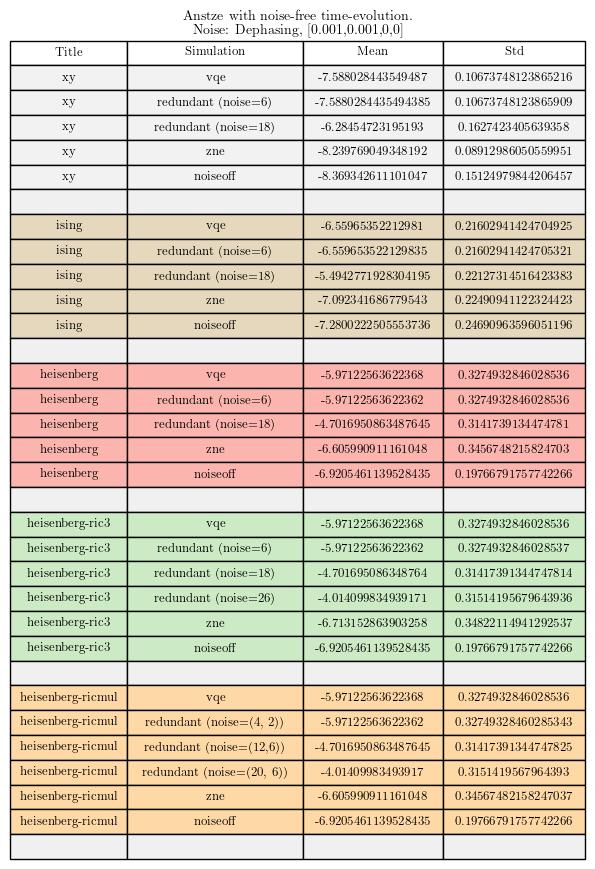

In [19]:
# Prepare rows as before
rows = []
for model, methods in ALL_PROCESSED_DATA.items():
    for method, stats in methods.items():
        if method == "redundant":
            for lvl, m, s in zip(stats['noise_levels'], stats['mean'], stats['std']):
                rows.append([model, f"{method} (noise={lvl})", m, s])
        elif stats:
            rows.append([model, method, stats['mean'], stats['std']])
        else:
            rows.append([model, method, "N/A", "N/A"])
    rows.append(["", "", "", ""])

df = pd.DataFrame(rows, columns=["Title", "Simulation", "Mean", "Std"])

unique_models = set(m.lower().strip() for m in df["Title"] if m.strip() != "")
colors = cm.Pastel1(np.linspace(0, 1, len(unique_models)))
model_colors = {model.lower(): colors[i] for i, model in enumerate(sorted(unique_models))}



fig, ax = plt.subplots()
ax.axis('off')

table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    cellLoc='center',
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(9)
table.auto_set_column_width(col=list(range(len(df.columns))))

for i, model_name in enumerate(df["Title"]):
    key = model_name.strip().lower()
    if key == "":
        for j in range(len(df.columns)):
            table[(i + 1, j)].set_facecolor("#f0f0f0")
        continue
    if key in model_colors:
        for j in range(len(df.columns)):
            table[(i + 1, j)].set_facecolor(model_colors[key])

# Draw the canvas and get the bounding box of the table
fig.canvas.draw()
bbox = table.get_window_extent(fig.canvas.get_renderer())

# Convert bbox from display units to inches
bbox_inches = bbox.transformed(fig.dpi_scale_trans.inverted())

# Resize the figure to tightly fit the table
fig.set_size_inches(bbox_inches.width, bbox_inches.height)
fig.suptitle("Anstze with noise-free time-evolution. \n Noise: Dephasing, [0.001,0.001,0,0]", fontsize=10, fontweight='bold', y=1.3)
# Remove margins by using add_axes with full figure and redraw
ax.set_position([0, 0, 1, 1])

plt.show()

### Saving as a PDF

In [20]:
HEIGHT = 0.2
WIDTH = 5
FILE_NAME = "result_summary.pdf"

# Flatten deeply nested dicts
def flatten_config(config, prefix=""):
    flat = {}
    for k, v in config.items():
        full_key = f"{prefix}{k}"
        if isinstance(v, dict):
            flat.update(flatten_config(v, prefix=full_key + "."))
        else:
            flat[full_key] = v
    return flat

def render_model_config_page(model_name, config_dict):
    flat_config = flatten_config(config_dict)
    df = pd.DataFrame(list(flat_config.items()), columns=["Parameter", "Value"])

    # Estimate height dynamically
    row_height = HEIGHT  # inches per row
    max_width = WIDTH  # keep A4 landscape width if needed
    fig_height = max(2, min(len(df) * row_height + 1.5, 11))

    fig = plt.figure(figsize=(max_width, fig_height))
    ax = fig.add_axes([0, 0, 1, 1])  # Full area, no margin
    ax.axis('off')

    table = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        cellLoc='left',
        loc='center',
    )

    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1, 1.3)  # Adjust row height for readability

    # Color header row
    for j in range(len(df.columns)):
        table[(0, j)].set_fontsize(9)
        table[(0, j)].set_facecolor("#dddddd")
        table[(0, j)].set_text_props(weight='bold')

    # Add title manually
    fig.text(0.5, 0.98, f"{model_name.upper()} CONFIGURATION", ha='center', fontsize=12, weight='bold')

    return fig

with PdfPages(FILE_NAME) as pdf:
    pdf.savefig(fig, bbox_inches='tight', pad_inches=0.05)
    plt.close(fig)

    for model, config in CONFIG_SUMMARY.items():
        config_fig = render_model_config_page(model, config)
        pdf.savefig(config_fig, bbox_inches='tight', pad_inches=0.1)  # <-- now really tight
        plt.close(config_fig)